# Домашнее задание 3 [10 баллов] 
# До 16.05.18 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.



# Классификация текстов с активным обучением


Зададимся простой задачей классификации текстов: например, классификацией отзывов на банки по тональности. Эта задача решается с достаточно высокими показателями качества с использованием стандартных алгоритмов классификации, например, сверточных нейронных сетей: корпус состоит из достаточного количества документов, чтобы сверточная сеть хорошо обучилась. Однако возникает естественный вопрос: действительно ли все документы нужны для того, чтобы достичь таких высоких показателей качества (или сопоставимых с ними). Парадигма активного обучения поможет вам ответить на этот вопрос.

## Часть 1. Предобработка данных [2 балла]

Коллекция отзывов хранится в файле banki_responses (https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0). Одна строчка в этом файле соответствует одному json-словарю. Из этого словаря вам понадобятся два значения по ключам text и rating -- текст отзыва и его оценка по шкале от 1 до 5.   

Считайте файл. Посчитайте, каких отзывов больше: положительных или отрицательных? 

Проведите предварительную обработку данных: удалите слишком короткие и слишком длинные тексты (пороги на длину определите самостоятельно). 

Разбейте данные на обучающее ($train$) и тестовое ($test$) множество случайным образом в отношеннии 3:1 (или любом другом отношении, которое покажется вам разумным). 

Задача классификации сформулирована так: по каждому отзыву определить его оценку (т.е. классификация на 5 классов). Признаками для классификации выступают слова.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Из отзывов мы хотим считать только эти поля

In [2]:
columns = ['rating_grade', 'text']

In [3]:
%%time
file_name = 'data/banki_responses.json'
data = []
with open(file_name, 'r') as f:
    for line in f:
        review_dict = json.loads(line)
        data.append([review_dict[k] for k in columns])

CPU times: user 40.8 s, sys: 2.01 s, total: 42.8 s
Wall time: 1min 6s


Для дальнейшего удобства обернем данные в pandas.DataFrame

In [4]:
df = pd.DataFrame(data, columns=columns)

In [5]:
df.dropna(inplace=True)

Дублировать столь много данных не круто

In [6]:
del data

### Посмотрим на данные

In [7]:
df.head()

,rating_grade,text
0,5.0,Здравствуйте! Хотелось бы выразить благодарно...
1,2.0,Уважаемые представители департамента по работе...
2,2.0,Здравствуйте. Столкнулась с такой ситуацией. в...
3,1.0,1 июня 2015 в Москве в отделении по адресу Смо...
4,1.0,История очень долгая! Пришел я в банк (это раз...


In [8]:
df.shape

(136189, 2)

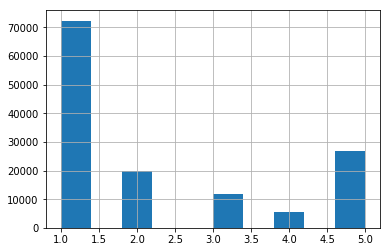

In [9]:
df['rating_grade'].hist()

Больше всего негативных отзывов. Классы сильно не сбалансированы

### Проведем предварительную обработку данных

Посмотрим на длину текстов

In [10]:
import nltk

In [13]:
%%time
df['char_len'] = df['text'].apply(lambda x: len(x))

CPU times: user 94.4 ms, sys: 9.08 ms, total: 104 ms
Wall time: 109 ms


In [14]:
%%time
df['word_len'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

CPU times: user 6min 22s, sys: 3.68 s, total: 6min 26s
Wall time: 6min 51s


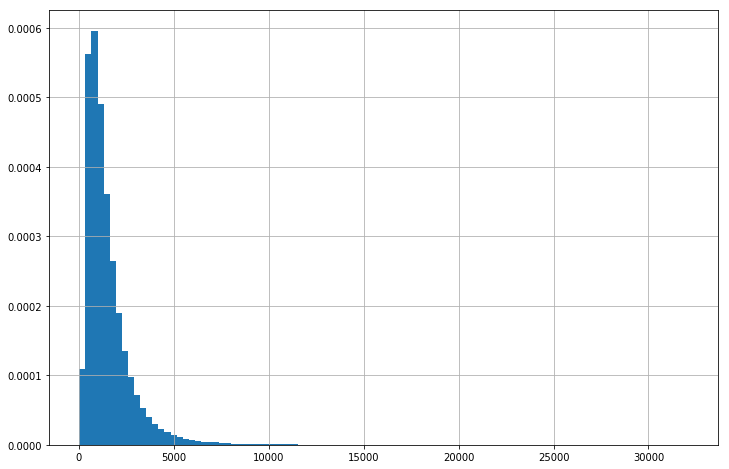

In [15]:
plt.figure(figsize=(12, 8))
df['char_len'].hist(bins=100, density=True)

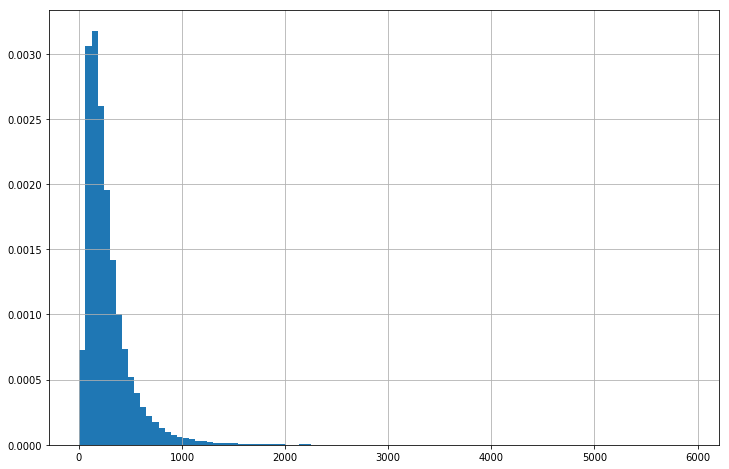

In [16]:
plt.figure(figsize=(12, 8))
df['word_len'].hist(bins=100, density=True)

Воспользуемся перцентилями для выбора слишком коротких и слишком длинных отзывов

Рассмотрим интервал с уровнем доверия 95%

In [17]:
lower_per = 2.5
upper_per = 97.5
print(upper_per - lower_per, "%")

95.0 %


In [18]:
lower_value = np.percentile(df['word_len'].values, lower_per)
upper_value = np.percentile(df['word_len'].values, upper_per)

In [19]:
print('Min words: ', lower_value, ' max words: ', upper_value)

Min words:  57.0  max words:  898.0


Выкинем лишние

In [20]:
df = df[df['word_len'] > lower_value][df['word_len'] <= upper_value].reset_index(drop=True)

/Users/maxim/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [21]:
df.shape

(129312, 4)

Выкинули порядка 7к отзывов

Чтобы не считать слова в разных формах разными, проведем лемматизацию текстов

Также выбросим стоп-слова и небуквенные символы(кроме "!"), так как они не несут смысловой нагрузки

In [22]:
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
from stop_words import get_stop_words

In [24]:
def post_to_words(raw_review, min_word_len=1):
    letters_only = re.sub("[^a-zа-я !]", " ", raw_review)
    
    stops = set(stopwords.words("russian"))
    meaningful_words = [word for sent in nltk.sent_tokenize(letters_only) 
             for word in nltk.word_tokenize(sent) if not word in stops and len(word) >= min_word_len]
    
    return " ".join(meaningful_words)


def lemmatize(data, min_word_len=1):
    """
    Use Mystem lemmer for data and remove word, which not contain letters.
    """
    lemmer = Mystem()
    useful_data = [''.join(lemmer.lemmatize(post_to_words(text, min_word_len))) for text in data]
    return useful_data

In [25]:
%%time
df['lem_text'] = lemmatize(df['text'].values, min_word_len=3)

CPU times: user 5min 7s, sys: 16.6 s, total: 5min 24s
Wall time: 18min 8s


### Подготовим обучающие и тестовые данные

Закодируем все слова в индексы

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/maxim/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/maxim/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [28]:
%%time
# prepare tokenizer
t = Tokenizer(filters='')
t.fit_on_texts(df['text'].values)
vocab_size = len(t.word_index) + 1

CPU times: user 45.3 s, sys: 793 ms, total: 46.1 s
Wall time: 47.4 s


In [29]:
vocab_size

826101

In [31]:
%%time
# integer encode the documents
encoded_docs = t.texts_to_sequences(df['text'].values)

CPU times: user 31.6 s, sys: 433 ms, total: 32.1 s
Wall time: 32.7 s


In [32]:
%%time
max_length = int(upper_value)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

CPU times: user 3.3 s, sys: 1.15 s, total: 4.45 s
Wall time: 5.09 s


Разобъем на train и test

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
df.shape

(129312, 5)

In [35]:
df['rating_grade'] = df['rating_grade'].apply(int)

In [36]:
indx_train, indx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), 
                                         stratify=df['rating_grade'].values, test_size=0.2, random_state=5)

In [37]:
y = df['rating_grade'].values - 1
y_train = df['rating_grade'].values[indx_train] - 1
y_test = df['rating_grade'].values[indx_test] - 1

X = padded_docs
X_train = padded_docs[indx_train]
X_test = padded_docs[indx_test]

## Часть 2. Baseline [4 балла]

Получите baseline классификации: в идеале, используйте сверточную нейронную сеть (слой эмбеддингов + свертка + субдескритизация). Число и размерность фильтров определите самостоятельно, так же как и использование регуляризаторов (dropout / batch norm) и их параметров. Так же самостоятельно (но обосновано) решите, использовать ли вам предобученные эмбеддинги или нет и проводить ли вам лемматизацию или нет. 

Обучите сеть на обучающем множестве и протестируйте на тестовом. Зафиксируйте baseline.

Если совсем трудно или вычисления занимают слишком много времени, используйте любой другой известный и симпатичный вам алгоритм классификации. 

In [38]:
import os

from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Dense, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

Построим модель

In [39]:
def build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., embed_l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, input_length=input_length, trainable=True,
                 embeddings_regularizer=regularizers.l2(embed_l2))
    )
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Обучим

In [40]:
def train_model(model, X, y, n_epoches, n_initial_epoch=0, batch_size=128, callbacks=[], **kwargs):
    return model.fit(X, y, batch_size=batch_size, epochs=n_epoches, initial_epoch=n_initial_epoch, 
                     validation_split=0.1, callbacks=callbacks)

Изобразим процесс обучения на графике

In [41]:
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

Сохраним

In [42]:
def get_last_n(path_to_folder):
    try:
        last_model_n = max(list(map(lambda name: int(name.replace('.h5', '').replace('.json', '').split('_')[-1]), 
                                     filter(lambda name: (name.startswith('model_weights_') or 
                                            name.startswith('model_weights_')), 
                                            os.listdir(path_to_folder)))))
    except:
        last_model_n = 0
    return last_model_n

def save_model(model, path_to_folder):
    last_n = get_last_n(path_to_folder)
    new_n = last_n + 1
    model.save_weights(os.path.join(path_to_folder, 'model_weights_' + str(new_n) + '.h5'))
    with open(os.path.join(path_to_folder, 'model_architecture_' + str(new_n) + '.json'), 'w') as f:
        f.write(model.to_json())
    print('Created:')
    print(os.path.join(path_to_folder, 'model_weights_' + str(new_n) + '.h5'))
    print(os.path.join(path_to_folder, 'model_architecture_' + str(new_n) + '.json'))

Посчитаем значение метрик на тесте

In [43]:
def eval_test_score(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test)
    print("Loss: {:.3f}, acc: {:.2f}%".format(loss, acc*100))
    return loss, acc

Теперь это все запустим

In [44]:
n_units = 192
lr = 0.00007
l2 = 1e-4
embed_l2 = 1e-4
output_size = 5
embedding_size = 40
input_length = max_length
model = build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr, 
                    dropout_rate=0.2, l2=l2, embed_l2=embed_l2)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 898, 40)           33044040  
_________________________________________________________________
dense_1 (Dense)              (None, 898, 192)          7872      
_________________________________________________________________
batch_normalization_1 (Batch (None, 898, 192)          768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 898, 192)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 172416)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 862085    
Total params: 33,914,765
Trainable params: 33,914,381
Non-trainable params: 384
______________________________________________________________

In [46]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                      batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/50
93104/93104 [==============================] - 1708s 18ms/step - loss: 2.8930 - acc: 0.5619 - val_loss: 2.4364 - val_acc: 0.5508
Epoch 2/50
93104/93104 [==============================] - 1609s 17ms/step - loss: 1.6932 - acc: 0.6826 - val_loss: 1.5791 - val_acc: 0.6709
Epoch 3/50
93104/93104 [==============================] - 1774s 19ms/step - loss: 1.2169 - acc: 0.7454 - val_loss: 1.3832 - val_acc: 0.6836
Epoch 4/50
93104/93104 [==============================] - 1823s 20ms/step - loss: 0.9404 - acc: 0.8066 - val_loss: 1.3137 - val_acc: 0.6528
Epoch 5/50
  512/93104 [..............................] - ETA: 30:52 - loss: 0.7329 - acc: 0.8945KeyboardInterrupt!
CPU times: user 4h 32min 20s, sys: 53min 24s, total: 5h 25min 44s
Wall time: 1h 55min 29s


In [49]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 213s 8ms/step
Loss: 1.305, acc: 66.07%


(1.3054688577976838, 0.6606735490924801)

Пошло переобучение

Сохраним модель

In [48]:
path_to_folder = 'data/models/'
save_model(model, path_to_folder)

Created:
data/models/model_weights_9.h5
data/models/model_architecture_9.json


## Смутно понимаю как именно влияет flatten слой на процесс обучения, но попробую его переставить

Построим модель

In [93]:
def build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., embed_l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, input_length=input_length, trainable=True,
                 embeddings_regularizer=regularizers.l2(embed_l2))
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
#     model.add(Flatten())
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Теперь это все запустим

In [51]:
n_units = 192
lr = 0.00007
l2 = 1e-4
embed_l2 = 1e-4
output_size = 5
embedding_size = 40
input_length = max_length
model = build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr, 
                    dropout_rate=0.2, l2=l2, embed_l2=embed_l2)

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 898, 40)           33044040  
_________________________________________________________________
flatten_2 (Flatten)          (None, 35920)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 192)               6896832   
_________________________________________________________________
batch_normalization_2 (Batch (None, 192)               768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 965       
Total params: 39,942,605
Trainable params: 39,942,221
Non-trainable params: 384
______________________________________________________________

In [53]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                      batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/50
93104/93104 [==============================] - 433s 5ms/step - loss: 3.2137 - acc: 0.4003 - val_loss: 2.5024 - val_acc: 0.5302
Epoch 2/50
93104/93104 [==============================] - 363s 4ms/step - loss: 1.8811 - acc: 0.6641 - val_loss: 1.6801 - val_acc: 0.6798
Epoch 3/50
93104/93104 [==============================] - 360s 4ms/step - loss: 1.3454 - acc: 0.7413 - val_loss: 1.5727 - val_acc: 0.6703
Epoch 4/50
93104/93104 [==============================] - 372s 4ms/step - loss: 1.0356 - acc: 0.8062 - val_loss: 1.6015 - val_acc: 0.5174
Epoch 5/50
93104/93104 [==============================] - 366s 4ms/step - loss: 0.7954 - acc: 0.8755 - val_loss: 1.5454 - val_acc: 0.5586
Epoch 6/50
12544/93104 [===>..........................] - ETA: 5:14 - loss: 0.6302 - acc: 0.9322KeyboardInterrupt!
CPU times: user 1h 5min 33s, sys: 19min 41s, total: 1h 25min 15s
Wall time: 32min 30s


In [54]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 63s 2ms/step
Loss: 1.480, acc: 65.77%


(1.4799070406765782, 0.6576963229392884)

Сново пошло переобучение. Во всяком случае flatten позволяет проводить вычисления быстрей. Видимо без него dense слой переводит каждое слово в тексте одной и той же матрицей весов из размерности 40 в 192, что не совсем то, чего мы хотим. И работает дольше, поскольку больше мелких матричных произведений(эффективней по ассимптотике бОльшие матрицы перемножить, но один раз)

Сохраним модель

In [55]:
path_to_folder = 'data/models/'
save_model(model, path_to_folder)

Created:
data/models/model_weights_10.h5
data/models/model_architecture_10.json


### Увеличим lr

Построим модель

In [132]:
def build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., embed_l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, input_length=input_length, trainable=True,
                 embeddings_regularizer=regularizers.l2(embed_l2))
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
#     model.add(Flatten())
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Теперь это все запустим

In [137]:
n_units = 192
lr = 0.0002
l2 = 1e-5
embed_l2 = 1e-4
output_size = 5
embedding_size = 40
input_length = max_length
model = build_model(vocab_size, embedding_size, input_length, n_units, output_size, lr, 
                    dropout_rate=0.3, l2=l2, embed_l2=embed_l2)

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 898, 40)           33044040  
_________________________________________________________________
flatten_16 (Flatten)         (None, 35920)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 192)               6896832   
_________________________________________________________________
batch_normalization_16 (Batc (None, 192)               768       
_________________________________________________________________
dropout_16 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 965       
Total params: 39,942,605
Trainable params: 39,942,221
Non-trainable params: 384
______________________________________________________________

In [139]:
%%time
n_epoches = 10
batch_size = 256
callbacks = [
#     EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                      batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/10
93104/93104 [==============================] - 367s 4ms/step - loss: 2.1488 - acc: 0.5322 - val_loss: 1.4714 - val_acc: 0.5912
Epoch 2/10
93104/93104 [==============================] - 376s 4ms/step - loss: 0.9991 - acc: 0.7471 - val_loss: 1.2443 - val_acc: 0.6801
Epoch 3/10
93104/93104 [==============================] - 353s 4ms/step - loss: 0.5416 - acc: 0.9052 - val_loss: 1.5058 - val_acc: 0.6738
Epoch 4/10
93104/93104 [==============================] - 379s 4ms/step - loss: 0.2853 - acc: 0.9837 - val_loss: 1.5514 - val_acc: 0.6350
Epoch 5/10
93104/93104 [==============================] - 353s 4ms/step - loss: 0.1881 - acc: 0.9984 - val_loss: 1.6773 - val_acc: 0.6446
Epoch 6/10
93104/93104 [==============================] - 360s 4ms/step - loss: 0.1433 - acc: 0.9997 - val_loss: 1.8166 - val_acc: 0.6158
Epoch 7/10
93104/93104 [==============================] - 356s 4ms/step - loss: 0.1140 - acc: 0.9998 - val_loss: 1.9212 - 

In [140]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 71s 3ms/step
Loss: 2.432, acc: 60.96%


(2.4322503431580005, 0.6095967211916179)

С увеличением lr модель переобучилась быстрей

### Обучим свои embedding'и

Из-за того что в embedding слое слишком много свободных параметров нейронка переобучается при больших lr и вообще почти не учится при его уменьшении(в коде остался второй вариант). Использовать предобученные на других данных embedding'и, как мне кажется, не самая лучшая идея для достижения хороших результатов, поскольку они не учитывают спицифику данной задачи(банковская сфера и ее словарь). Так что обучим свои, пусть и плохие

In [57]:
import gensim
from sklearn.decomposition import PCA

Функция, подготавливающая данные для w2v

In [161]:
def sentences_for_w2v(data):
    """
    Use Mystem lemmer for data and remove word, which not contain letters.
    """
    lemmer = Mystem()
#     sentences = [''.join(lemmer.lemmatize(post_to_words(sent))) 
#                  for text in data for sent in nltk.sent_tokenize(text)]
    sentences = [[word for word in lemmer.lemmatize(post_to_words(sent))]
                 for text in data for sent in nltk.sent_tokenize(text.lower())]
    return sentences

Подготовим данные для обучения w2v

In [165]:
%%time
sentences = sentences_for_w2v(df['text'].values)

CPU times: user 18min 44s, sys: 2min 6s, total: 20min 50s
Wall time: 36min 33s


Обучим модель w2v

In [181]:
%%time
embedding_size = 50
# train model(skip-gram, negative sampling)
w2v_model = gensim.models.Word2Vec(sentences, size=embedding_size, min_count=3, window=5, iter=100, sg=1, 
                                   alpha=0.03, min_alpha=0.0005, hs=0, negative=20, seed=0, compute_loss=True)

CPU times: user 10h 37min 15s, sys: 3min 35s, total: 10h 40min 50s
Wall time: 3h 48min 50s


In [182]:
# summarize the loaded model
print(w2v_model)

Word2Vec(vocab=39335, size=50, alpha=0.03)


In [183]:
# save model
w2v_model.save('data/w2v/w2v_model.bin')
w2v_model.wv.save_word2vec_format('data/w2v/w2v_model_binary.bin', binary=True)
# load model
new_w2v_model = gensim.models.Word2Vec.load('data/w2v/w2v_model.bin')
print(new_w2v_model)

Word2Vec(vocab=39335, size=50, alpha=0.03)


Изобразим эти векторы в 2-d

In [184]:
# fit a 2d PCA model to the vectors
X = w2v_model[w2v_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

/Users/maxim/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


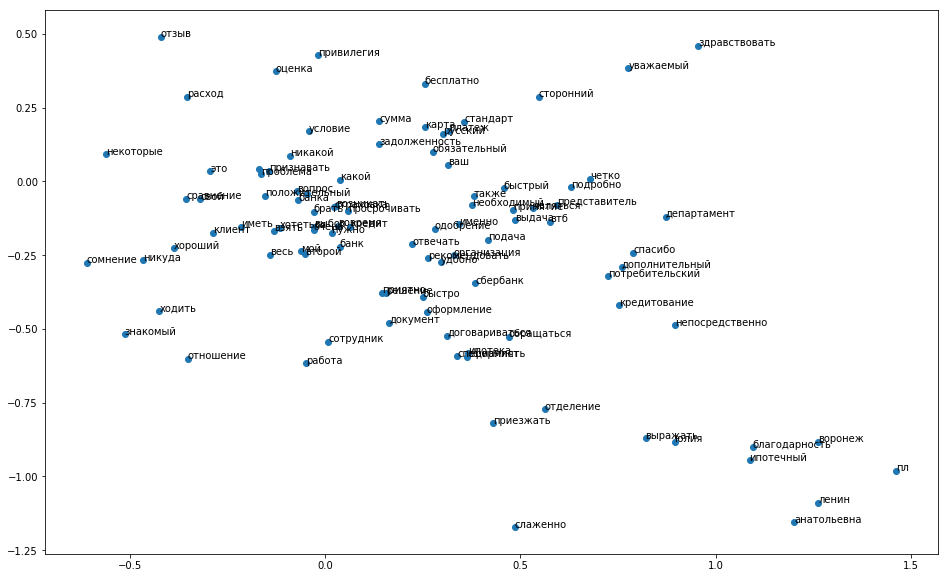

In [185]:
# create a scatter plot of the projection
n_words = 100
plt.figure(figsize=(16, 10))
plt.scatter(result[:n_words, 0], result[:n_words, 1])
words = list(w2v_model.wv.vocab)
for i, word in enumerate(words[:n_words]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Поиграем с близостью слов

In [186]:
w2v_model.most_similar('банк')

/Users/maxim/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('втб', 0.8088374137878418),
 ('бм', 0.7948548197746277),
 ('уралсиб', 0.7918426394462585),
 ('банка', 0.7904466390609741),
 ('росбанк', 0.7856262922286987),
 ('сити', 0.7848443984985352),
 ('рс', 0.7811917662620544),
 ('псб', 0.778639018535614),
 ('бб', 0.77851802110672),
 ('ситибанк', 0.7768324613571167)]

### Используем эти embedding'и в нейронке

Загрузим обученную модель

In [107]:
# load model
w2v_model = gensim.models.Word2Vec.load('data/w2v/w2v_model.bin')
print(w2v_model)

Word2Vec(vocab=39335, size=50, alpha=0.03)


Создадим матирцу embedding

In [109]:
%%time
embedding_size = 50
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model.wv.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

CPU times: user 1.17 s, sys: 64.8 ms, total: 1.23 s
Wall time: 1.25 s


#### Построим модель с замороженным embedding слоем

In [110]:
def build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=input_length, 
                  trainable=False)
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Теперь это все запустим

In [115]:
n_units = 192
lr = 0.0005
l2 = 1e-6
output_size = 5
embedding_size = 50
input_length = max_length
model = build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr, 
                    dropout_rate=0.4, l2=l2)

In [116]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 898, 50)           41305050  
_________________________________________________________________
flatten_12 (Flatten)         (None, 44900)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 192)               8620992   
_________________________________________________________________
batch_normalization_12 (Batc (None, 192)               768       
_________________________________________________________________
dropout_12 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 965       
Total params: 49,927,775
Trainable params: 8,622,341
Non-trainable params: 41,305,434
________________________________________________________

In [117]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                          batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/50
93104/93104 [==============================] - 141s 2ms/step - loss: 1.3156 - acc: 0.5583 - val_loss: 1.0562 - val_acc: 0.6387
Epoch 2/50
93104/93104 [==============================] - 141s 2ms/step - loss: 0.9105 - acc: 0.6752 - val_loss: 1.0964 - val_acc: 0.6410
Epoch 3/50
93104/93104 [==============================] - 145s 2ms/step - loss: 0.7709 - acc: 0.7202 - val_loss: 1.1291 - val_acc: 0.6294
CPU times: user 18min 10s, sys: 1min 38s, total: 19min 49s
Wall time: 7min 7s


In [118]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 26s 1ms/step
Loss: 1.116, acc: 63.00%


(1.1157661659675246, 0.6300119862420761)

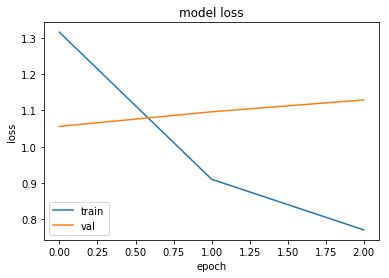

In [119]:
history_plot(history)

С замороженными весами тоже переобучается

#### Построим модель с обучающимся embedding слоем

In [120]:
def build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., embed_l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=input_length, 
                  trainable=True, embeddings_regularizer=regularizers.l2(embed_l2))
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Теперь это все запустим

In [121]:
n_units = 192
lr = 0.0007
l2 = 1e-6
embed_l2=1e-7
output_size = 5
input_length = max_length
model = build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr, 
                    dropout_rate=0.5, l2=l2)

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 898, 50)           41305050  
_________________________________________________________________
flatten_13 (Flatten)         (None, 44900)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 192)               8620992   
_________________________________________________________________
batch_normalization_13 (Batc (None, 192)               768       
_________________________________________________________________
dropout_13 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 965       
Total params: 49,927,775
Trainable params: 49,927,391
Non-trainable params: 384
______________________________________________________________

In [123]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                          batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/50
93104/93104 [==============================] - 426s 5ms/step - loss: 1.1543 - acc: 0.6011 - val_loss: 0.9185 - val_acc: 0.6841
Epoch 2/50
93104/93104 [==============================] - 397s 4ms/step - loss: 0.7937 - acc: 0.7093 - val_loss: 1.0041 - val_acc: 0.6834
Epoch 3/50
93104/93104 [==============================] - 410s 4ms/step - loss: 0.5936 - acc: 0.7748 - val_loss: 1.1194 - val_acc: 0.6685
CPU times: user 39min 50s, sys: 15min 3s, total: 54min 53s
Wall time: 20min 34s


In [124]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 28s 1ms/step
Loss: 1.103, acc: 66.84%


(1.1028953953970753, 0.6683679387611188)

С разморозка весов embedding'а не помогла(да и не должна была помочь от переобучения). Просто интересно было попробовать инициализировать матрицу embedding'ов

In [125]:
path_to_folder = 'data/models/'
save_model(model, path_to_folder)

Created:
data/models/model_weights_12.h5
data/models/model_architecture_12.json


### Используем facebook embedding'и в нейронке

Загрузим embedding в память

In [81]:
%%time
file_name = '../HW_2/data/wiki.ru.vec'
embeddings_index = dict()
with open(file_name) as f:
    line = f.readline()
    n_words, embedding_size = map(int, line.split())
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1862490 word vectors.
CPU times: user 2min 34s, sys: 10.1 s, total: 2min 44s
Wall time: 2min 56s


Создадим матирцу embedding

In [82]:
%%time
n_words_in_embedding = 0
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        n_words_in_embedding += 1

CPU times: user 1.72 s, sys: 2.25 s, total: 3.96 s
Wall time: 5.64 s


In [83]:
print(n_words_in_embedding)

157506


In [84]:
del embeddings_index

Построим модель с замороженным embedding слоем

In [97]:
def build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=input_length, 
                  trainable=False)
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Теперь это все запустим

In [98]:
n_units = 192
lr = 0.0005
l2 = 1e-6
output_size = 5
input_length = max_length
embedding_size = 300
model = build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr, 
                    dropout_rate=0.2, l2=l2)

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 898, 300)          247830300 
_________________________________________________________________
flatten_10 (Flatten)         (None, 269400)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 192)               51724992  
_________________________________________________________________
batch_normalization_10 (Batc (None, 192)               768       
_________________________________________________________________
dropout_10 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 965       
Total params: 299,557,025
Trainable params: 51,726,341
Non-trainable params: 247,830,684
_____________________________________________________

In [100]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                          batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 1/50
93104/93104 [==============================] - 1035s 11ms/step - loss: 1.2567 - acc: 0.5552 - val_loss: 1.0405 - val_acc: 0.6424
Epoch 2/50
93104/93104 [==============================] - 1071s 12ms/step - loss: 0.8905 - acc: 0.6768 - val_loss: 1.3597 - val_acc: 0.5125
Epoch 3/50
93104/93104 [==============================] - 1037s 11ms/step - loss: 0.6900 - acc: 0.7432 - val_loss: 1.2341 - val_acc: 0.6304
CPU times: user 2h 52s, sys: 28min 35s, total: 2h 29min 27s
Wall time: 52min 23s


In [101]:
eval_test_score(model, X_test, y_test)

25863/25863 [==============================] - 179s 7ms/step
Loss: 1.220, acc: 63.19%


(1.2198752796770234, 0.6319452499779149)

In [102]:
%%time
n_epoches = 50
batch_size = 256
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size)
]
try:
    history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=3, 
                          batch_size=batch_size, callbacks=callbacks)
except:
    print('KeyboardInterrupt!')

Train on 93104 samples, validate on 10345 samples
Epoch 4/50
93104/93104 [==============================] - 1035s 11ms/step - loss: 0.5243 - acc: 0.8067 - val_loss: 1.2878 - val_acc: 0.5822
Epoch 5/50
 1792/93104 [..............................] - ETA: 16:56 - loss: 0.3863 - acc: 0.8677KeyboardInterrupt!
CPU times: user 39min 6s, sys: 9min 22s, total: 48min 29s
Wall time: 17min 37s


Все равно оверфит

## Часть 3. Baseline [4 балла] Активное обучение

Подход активного обучения основан на следующей идее: вместо всего обучающего множества мы используем его маленькие фрагменты, в которых модель неуверена для обучения. Таким образом, модель обучается исключительно по **трудным** объектам, число которых существенно меньше, чем общее число объектов.

Обучение модели начинается с обучения по $N$ случайно выбранным примерам, где $N$ – небольшое число (100, 200 и т.д.). Затем модель тестируется на $|train| - N$ объектах, после чего из  $|train| - N$ объектов выбираются снова $N$  объектов, в которых модель не уверена. Эти объекты используются для дообучения модели. Процесс выбора $N$ трудных объектов и дообучения на них повторяется некоторое количество раз (100, 200 и т.д. раз). На каждом шаге активного обучения модель можно протестировать на тестовом множестве, чтобы сравнить ее качества с baseline.

Как выбирать трудные объекты:
1. Выход нейронной сети - оценки 5 вероятностей принадлежности объекта одному из классов. Предсказанный класс – это тот класс, вероятность которого максимальна. Отсортируем объекты по убыванию вероятности предсказанного класса ($\min \max p_i$) и выберем $N$ первых объектов;
2. Используем энтропию: чем больше энтропия предсказания, тем ближе распределение вероятностей предсказания к равномерному распределению, тем труднее объект. 

In [211]:
import timeit
from tqdm import tqdm

In [261]:
def build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=input_length, 
                  trainable=False)
    )
    model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [285]:
class ActiveTrainer:
    def __init__(self, model):
        self.model = model
        
    def train(self, X, y, N=128, n_epoches=10):
        # будем искать только от 20% данных
        idx_val, idx_test = train_test_split(
            np.arange(y.shape[0], dtype='int32'), test_size=0.2, train_size=0.05, 
            random_state=5, shuffle=True, stratify=y)
        idx_train = []
        X_test, y_test = X[idx_test], y[idx_test]
        X_val, y_val = X[idx_val], y[idx_val]
        for epoch in tqdm(range(n_epoches)):
            # выберем объекты для активного обучения и для генерации следующего train'а
            idx = self.get_complex_obj_indexes(X_test, y_test)
            idx_train = idx[:N]
            other_idx = np.array([i for i in np.arange(y.shape[0], dtype='int32') 
                                  if i not in idx_train and i not in idx_val])
            
            _, idx_test = train_test_split(other_idx, stratify=y[other_idx], 
                                           test_size=0.2, random_state=5, shuffle=True)
            X_train, X_test = X[idx_train], X[idx_test]
            y_train, y_test = y[idx_train], y[idx_test]
            # обучим модель на этих объектах
            model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epoch + 1, initial_epoch=epoch, batch_size=N)
        
    def get_complex_obj_indexes(self, X, y):
        start_time = timeit.default_timer()
        y_pred_probas = self.model.predict(X, batch_size=4096, verbose=1)
        run_time = timeit.default_timer() - start_time
        entropy = -np.log(y_pred_probas)[np.arange(y.shape[0]), y]
        print("Run time for eval indexes: {:.2f} sec".format(run_time))
        return np.argsort(entropy)[::-1]
    
    def get_test_acc_and_loss(self, X, y):
        loss, acc = self.model.evaluate(X, y)
        print("Loss: {:.3f}, acc: {:.2f}%".format(loss, acc*100))
        return loss, acc

Создадим модель для активного обучения

In [273]:
n_units = 192
lr = 0.001
l2 = 1e-8
output_size = 5
input_length = max_length
model = build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr, 
                    dropout_rate=0.2, l2=l2)

In [274]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 867, 50)           51673350  
_________________________________________________________________
flatten_24 (Flatten)         (None, 43350)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 192)               8323392   
_________________________________________________________________
batch_normalization_24 (Batc (None, 192)               768       
_________________________________________________________________
dropout_24 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 965       
Total params: 59,998,475
Trainable params: 8,324,741
Non-trainable params: 51,673,734
________________________________________________________

Начнем ее "активно" обучать

In [275]:
%%time
N = 128
trainer = ActiveTrainer(model)
try:
    trainer.train(X_train, y_train, N, n_epoches=40)
except:
    print('KeyboardInterapt!')


  0%|          | 0/40 [00:00<?, ?it/s]
Exception in thread Thread-431:
Traceback (most recent call last):
  File "/Users/maxim/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/maxim/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/maxim/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



20628/20628 [==============================] - 13s 626us/step
Run time for eval indexes: 12.91 sec
Train on 128 samples, validate on 5157 samples
Epoch 1/1
128/128 [==============================] - 7s 53ms/step - loss: 2.4738 - acc: 0.2109 - val_loss: 1.6094 - val_acc: 0.2360


  2%|▎         | 1/40 [00:23<15:29, 23.82s/it]

19573/19573 [==============================] - 12s 609us/step
Run time for eval indexes: 11.92 sec
Train on 128 samples, validate on 5157 samples
Epoch 2/2
128/128 [==============================] - 5s 36ms/step - loss: 3.0884 - acc: 0.1641 - val_loss: 1.6548 - val_acc: 0.1966


  5%|▌         | 2/40 [00:44<13:59, 22.10s/it]

19573/19573 [==============================] - 11s 542us/step
Run time for eval indexes: 10.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 3/3
128/128 [==============================] - 5s 36ms/step - loss: 3.0024 - acc: 0.1641 - val_loss: 1.6988 - val_acc: 0.1887


  8%|▊         | 3/40 [01:01<12:39, 20.52s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 4/4
128/128 [==============================] - 5s 38ms/step - loss: 2.6901 - acc: 0.2656 - val_loss: 1.6919 - val_acc: 0.2116


 10%|█         | 4/40 [01:19<11:51, 19.77s/it]

19573/19573 [==============================] - 11s 580us/step
Run time for eval indexes: 11.37 sec
Train on 128 samples, validate on 5157 samples
Epoch 5/5
128/128 [==============================] - 5s 36ms/step - loss: 2.5084 - acc: 0.2812 - val_loss: 1.6583 - val_acc: 0.2424


 12%|█▎        | 5/40 [01:37<11:19, 19.42s/it]

19573/19573 [==============================] - 11s 552us/step
Run time for eval indexes: 10.81 sec
Train on 128 samples, validate on 5157 samples
Epoch 6/6
128/128 [==============================] - 4s 35ms/step - loss: 2.2376 - acc: 0.3203 - val_loss: 1.6189 - val_acc: 0.2808


 15%|█▌        | 6/40 [01:54<10:48, 19.06s/it]

19572/19572 [==============================] - 11s 552us/step
Run time for eval indexes: 10.81 sec
Train on 128 samples, validate on 5157 samples
Epoch 7/7
128/128 [==============================] - 5s 36ms/step - loss: 2.3360 - acc: 0.2344 - val_loss: 1.5778 - val_acc: 0.3137


 18%|█▊        | 7/40 [02:11<10:18, 18.75s/it]

19573/19573 [==============================] - 11s 550us/step
Run time for eval indexes: 10.77 sec
Train on 128 samples, validate on 5157 samples
Epoch 8/8
128/128 [==============================] - 5s 37ms/step - loss: 2.0028 - acc: 0.3125 - val_loss: 1.5564 - val_acc: 0.3384


 20%|██        | 8/40 [02:28<09:52, 18.53s/it]

19572/19572 [==============================] - 11s 546us/step
Run time for eval indexes: 10.70 sec
Train on 128 samples, validate on 5157 samples
Epoch 9/9
128/128 [==============================] - 5s 36ms/step - loss: 1.8041 - acc: 0.3672 - val_loss: 1.5393 - val_acc: 0.3597


 22%|██▎       | 9/40 [02:45<09:28, 18.34s/it]

19573/19573 [==============================] - 13s 640us/step
Run time for eval indexes: 12.54 sec
Train on 128 samples, validate on 5157 samples
Epoch 10/10
128/128 [==============================] - 6s 45ms/step - loss: 1.8479 - acc: 0.3594 - val_loss: 1.5206 - val_acc: 0.3869


 25%|██▌       | 10/40 [03:05<09:16, 18.54s/it]

19573/19573 [==============================] - 12s 599us/step
Run time for eval indexes: 11.73 sec
Train on 128 samples, validate on 5157 samples
Epoch 11/11
128/128 [==============================] - 7s 54ms/step - loss: 2.1027 - acc: 0.3125 - val_loss: 1.5058 - val_acc: 0.4045


 28%|██▊       | 11/40 [03:25<09:02, 18.71s/it]

19573/19573 [==============================] - 23s 1ms/step
Run time for eval indexes: 22.73 sec
Train on 128 samples, validate on 5157 samples
Epoch 12/12
128/128 [==============================] - 7s 56ms/step - loss: 1.6036 - acc: 0.2969 - val_loss: 1.4910 - val_acc: 0.4171


 30%|███       | 12/40 [03:57<09:14, 19.81s/it]

19572/19572 [==============================] - 13s 670us/step
Run time for eval indexes: 13.13 sec
Train on 128 samples, validate on 5157 samples
Epoch 13/13
128/128 [==============================] - 6s 44ms/step - loss: 1.6609 - acc: 0.3516 - val_loss: 1.4833 - val_acc: 0.4299


 32%|███▎      | 13/40 [04:18<08:56, 19.89s/it]

19573/19573 [==============================] - 14s 724us/step
Run time for eval indexes: 14.17 sec
Train on 128 samples, validate on 5157 samples
Epoch 14/14
128/128 [==============================] - 5s 42ms/step - loss: 1.4394 - acc: 0.4531 - val_loss: 1.4749 - val_acc: 0.4404


 35%|███▌      | 14/40 [04:39<08:39, 19.99s/it]

19572/19572 [==============================] - 11s 587us/step
Run time for eval indexes: 11.50 sec
Train on 128 samples, validate on 5157 samples
Epoch 15/15
128/128 [==============================] - 5s 42ms/step - loss: 1.5353 - acc: 0.4453 - val_loss: 1.4740 - val_acc: 0.4410


 38%|███▊      | 15/40 [04:58<08:17, 19.88s/it]

19573/19573 [==============================] - 12s 593us/step
Run time for eval indexes: 11.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 16/16
128/128 [==============================] - 6s 43ms/step - loss: 1.7732 - acc: 0.3750 - val_loss: 1.4685 - val_acc: 0.4439


 40%|████      | 16/40 [05:16<07:55, 19.81s/it]

19573/19573 [==============================] - 12s 595us/step
Run time for eval indexes: 11.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 17/17
128/128 [==============================] - 6s 44ms/step - loss: 1.4314 - acc: 0.4531 - val_loss: 1.4568 - val_acc: 0.4518


 42%|████▎     | 17/40 [05:35<07:34, 19.75s/it]

19573/19573 [==============================] - 12s 589us/step
Run time for eval indexes: 11.54 sec
Train on 128 samples, validate on 5157 samples
Epoch 18/18
128/128 [==============================] - 6s 43ms/step - loss: 1.5067 - acc: 0.4609 - val_loss: 1.4427 - val_acc: 0.4607


 45%|████▌     | 18/40 [05:54<07:13, 19.69s/it]

19573/19573 [==============================] - 12s 594us/step
Run time for eval indexes: 11.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 19/19
128/128 [==============================] - 5s 42ms/step - loss: 1.5736 - acc: 0.3906 - val_loss: 1.4309 - val_acc: 0.4658


 48%|████▊     | 19/40 [06:13<06:52, 19.63s/it]

19572/19572 [==============================] - 12s 593us/step
Run time for eval indexes: 11.60 sec
Train on 128 samples, validate on 5157 samples
Epoch 20/20
128/128 [==============================] - 5s 43ms/step - loss: 1.2191 - acc: 0.6016 - val_loss: 1.4200 - val_acc: 0.4737


 50%|█████     | 20/40 [06:31<06:31, 19.58s/it]

19573/19573 [==============================] - 12s 593us/step
Run time for eval indexes: 11.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 21/21
128/128 [==============================] - 5s 43ms/step - loss: 1.3055 - acc: 0.4844 - val_loss: 1.4090 - val_acc: 0.4865


 52%|█████▎    | 21/40 [06:50<06:11, 19.53s/it]

19573/19573 [==============================] - 12s 592us/step
Run time for eval indexes: 11.59 sec
Train on 128 samples, validate on 5157 samples
Epoch 22/22
128/128 [==============================] - 5s 43ms/step - loss: 1.2420 - acc: 0.5781 - val_loss: 1.3993 - val_acc: 0.5013


 55%|█████▌    | 22/40 [07:08<05:50, 19.49s/it]

19573/19573 [==============================] - 12s 593us/step
Run time for eval indexes: 11.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 23/23
128/128 [==============================] - 5s 40ms/step - loss: 1.4942 - acc: 0.3906 - val_loss: 1.3930 - val_acc: 0.5106


 57%|█████▊    | 23/40 [07:27<05:30, 19.44s/it]

19573/19573 [==============================] - 12s 629us/step
Run time for eval indexes: 12.32 sec
Train on 128 samples, validate on 5157 samples
Epoch 24/24
128/128 [==============================] - 5s 43ms/step - loss: 1.2727 - acc: 0.5312 - val_loss: 1.3888 - val_acc: 0.5127


 60%|██████    | 24/40 [07:46<05:10, 19.44s/it]

19573/19573 [==============================] - 12s 620us/step
Run time for eval indexes: 12.15 sec
Train on 128 samples, validate on 5157 samples
Epoch 25/25
128/128 [==============================] - 5s 36ms/step - loss: 1.1099 - acc: 0.5781 - val_loss: 1.3881 - val_acc: 0.5137


 62%|██████▎   | 25/40 [08:04<04:50, 19.39s/it]

19573/19573 [==============================] - 12s 591us/step
Run time for eval indexes: 11.58 sec
Train on 128 samples, validate on 5157 samples
Epoch 26/26
128/128 [==============================] - 5s 43ms/step - loss: 1.0870 - acc: 0.5859 - val_loss: 1.3905 - val_acc: 0.5174


 65%|██████▌   | 26/40 [08:23<04:30, 19.35s/it]

19572/19572 [==============================] - 12s 591us/step
Run time for eval indexes: 11.58 sec
Train on 128 samples, validate on 5157 samples
Epoch 27/27
128/128 [==============================] - 5s 41ms/step - loss: 1.3480 - acc: 0.5156 - val_loss: 1.3936 - val_acc: 0.5168


 68%|██████▊   | 27/40 [08:41<04:11, 19.32s/it]

19572/19572 [==============================] - 12s 603us/step
Run time for eval indexes: 11.81 sec
Train on 128 samples, validate on 5157 samples
Epoch 28/28
128/128 [==============================] - 5s 42ms/step - loss: 0.8628 - acc: 0.7734 - val_loss: 1.3913 - val_acc: 0.5168


 70%|███████   | 28/40 [09:00<03:51, 19.30s/it]

19573/19573 [==============================] - 12s 590us/step
Run time for eval indexes: 11.56 sec
Train on 128 samples, validate on 5157 samples
Epoch 29/29
128/128 [==============================] - 5s 43ms/step - loss: 1.1489 - acc: 0.6250 - val_loss: 1.3870 - val_acc: 0.5174


 72%|███████▎  | 29/40 [09:18<03:31, 19.27s/it]

19572/19572 [==============================] - 12s 593us/step
Run time for eval indexes: 11.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 30/30
128/128 [==============================] - 5s 42ms/step - loss: 1.3837 - acc: 0.4844 - val_loss: 1.3820 - val_acc: 0.5154


 75%|███████▌  | 30/40 [09:37<03:12, 19.24s/it]

19572/19572 [==============================] - 12s 595us/step
Run time for eval indexes: 11.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 31/31
128/128 [==============================] - 5s 43ms/step - loss: 1.0199 - acc: 0.6562 - val_loss: 1.3750 - val_acc: 0.5111


 78%|███████▊  | 31/40 [09:55<02:53, 19.22s/it]

19572/19572 [==============================] - 12s 596us/step
Run time for eval indexes: 11.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 32/32
128/128 [==============================] - 6s 44ms/step - loss: 1.2389 - acc: 0.5547 - val_loss: 1.3699 - val_acc: 0.5108


 80%|████████  | 32/40 [10:14<02:33, 19.21s/it]

19573/19573 [==============================] - 12s 632us/step
Run time for eval indexes: 12.38 sec
Train on 128 samples, validate on 5157 samples
Epoch 33/33
128/128 [==============================] - 6s 44ms/step - loss: 1.2861 - acc: 0.5703 - val_loss: 1.3667 - val_acc: 0.5104


 82%|████████▎ | 33/40 [10:34<02:14, 19.22s/it]

19572/19572 [==============================] - 13s 643us/step
Run time for eval indexes: 12.59 sec
Train on 128 samples, validate on 5157 samples
Epoch 34/34
128/128 [==============================] - 5s 42ms/step - loss: 1.2806 - acc: 0.5234 - val_loss: 1.3630 - val_acc: 0.5071


 85%|████████▌ | 34/40 [10:53<01:55, 19.23s/it]

19573/19573 [==============================] - 12s 591us/step
Run time for eval indexes: 11.58 sec
Train on 128 samples, validate on 5157 samples
Epoch 35/35
128/128 [==============================] - 5s 41ms/step - loss: 1.0805 - acc: 0.6250 - val_loss: 1.3591 - val_acc: 0.5080


 88%|████████▊ | 35/40 [11:12<01:36, 19.21s/it]

19573/19573 [==============================] - 12s 592us/step
Run time for eval indexes: 11.61 sec
Train on 128 samples, validate on 5157 samples
Epoch 36/36
128/128 [==============================] - 5s 42ms/step - loss: 1.0733 - acc: 0.6094 - val_loss: 1.3551 - val_acc: 0.5092


 90%|█████████ | 36/40 [11:30<01:16, 19.19s/it]

19573/19573 [==============================] - 12s 602us/step
Run time for eval indexes: 11.79 sec
Train on 128 samples, validate on 5157 samples
Epoch 37/37
128/128 [==============================] - 6s 44ms/step - loss: 1.1920 - acc: 0.5859 - val_loss: 1.3556 - val_acc: 0.5150


 92%|█████████▎| 37/40 [11:49<00:57, 19.18s/it]

19572/19572 [==============================] - 12s 599us/step
Run time for eval indexes: 11.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 38/38
128/128 [==============================] - 6s 43ms/step - loss: 0.9290 - acc: 0.7578 - val_loss: 1.3578 - val_acc: 0.5197


 95%|█████████▌| 38/40 [12:08<00:38, 19.17s/it]

19572/19572 [==============================] - 12s 594us/step
Run time for eval indexes: 11.63 sec
Train on 128 samples, validate on 5157 samples
Epoch 39/39
128/128 [==============================] - 5s 43ms/step - loss: 1.0978 - acc: 0.6484 - val_loss: 1.3567 - val_acc: 0.5197


 98%|█████████▊| 39/40 [12:27<00:19, 19.15s/it]

19573/19573 [==============================] - 12s 637us/step
Run time for eval indexes: 12.47 sec
Train on 128 samples, validate on 5157 samples
Epoch 40/40
128/128 [==============================] - 5s 43ms/step - loss: 1.1183 - acc: 0.6016 - val_loss: 1.3566 - val_acc: 0.5158


100%|██████████| 40/40 [12:46<00:00, 19.16s/it]

CPU times: user 28min 9s, sys: 2min 17s, total: 30min 26s
Wall time: 12min 49s


Посмотрим на конечное качество

In [276]:
%%time
trainer.get_test_acc_and_loss(X_test, y_test)

25786/25786 [==============================] - 27s 1ms/step
Loss: 1.369, acc: 50.94%
CPU times: user 59.3 s, sys: 6.41 s, total: 1min 5s
Wall time: 27.4 s


(1.3694222779766987, 0.5094237183244883)

Сохраним модель

In [284]:
path_to_folder = 'data/models/'
save_model(trainer.model, path_to_folder)

Created:
data/models/model_weights_8.h5
data/models/model_architecture_8.json


Уменьшим lr и попробуем дообучить модель

In [286]:
n_units = 192
lr = 0.0002
l2 = 1e-8
output_size = 5
input_length = max_length
model = build_model(vocab_size, embedding_size, embedding_matrix, input_length, n_units, output_size, lr, 
                    dropout_rate=0.2, l2=l2)

Загрузим веса

In [287]:
model.load_weights('data/models/model_weights_8.h5')

In [288]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 867, 50)           51673350  
_________________________________________________________________
flatten_26 (Flatten)         (None, 43350)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 192)               8323392   
_________________________________________________________________
batch_normalization_26 (Batc (None, 192)               768       
_________________________________________________________________
dropout_26 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 965       
Total params: 59,998,475
Trainable params: 8,324,741
Non-trainable params: 51,673,734
________________________________________________________

Начнем ее "активно" обучать

In [289]:
%%time
N = 128
trainer = ActiveTrainer(model)
try:
    trainer.train(X_train, y_train, N, n_epoches=100)
except:
    print('KeyboardInterapt!')


  0%|          | 0/100 [00:00<?, ?it/s]

16384/20628 [======================>.......] - ETA: 2s


Exception in thread Thread-432:
Traceback (most recent call last):
  File "/Users/maxim/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/maxim/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/maxim/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



20628/20628 [==============================] - 12s 567us/step
Run time for eval indexes: 11.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 1/1
128/128 [==============================] - 5s 43ms/step - loss: 0.7211 - acc: 0.7656 - val_loss: 1.3554 - val_acc: 0.5220


  1%|          | 1/100 [00:19<31:54, 19.33s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 2/2
128/128 [==============================] - 3s 27ms/step - loss: 0.8721 - acc: 0.7109 - val_loss: 1.3559 - val_acc: 0.5234


  2%|▏         | 2/100 [00:34<28:30, 17.45s/it]

19572/19572 [==============================] - 12s 600us/step
Run time for eval indexes: 11.75 sec
Train on 128 samples, validate on 5157 samples
Epoch 3/3
128/128 [==============================] - 3s 24ms/step - loss: 1.1642 - acc: 0.6250 - val_loss: 1.3566 - val_acc: 0.5239


  3%|▎         | 3/100 [00:51<27:34, 17.05s/it]

19573/19573 [==============================] - 12s 622us/step
Run time for eval indexes: 12.18 sec
Train on 128 samples, validate on 5157 samples
Epoch 4/4
128/128 [==============================] - 4s 29ms/step - loss: 1.2001 - acc: 0.5859 - val_loss: 1.3564 - val_acc: 0.5251


  4%|▍         | 4/100 [01:08<27:22, 17.11s/it]

19573/19573 [==============================] - 11s 569us/step
Run time for eval indexes: 11.13 sec
Train on 128 samples, validate on 5157 samples
Epoch 5/5
128/128 [==============================] - 3s 24ms/step - loss: 0.8779 - acc: 0.7188 - val_loss: 1.3561 - val_acc: 0.5255


  5%|▌         | 5/100 [01:24<26:36, 16.81s/it]

19573/19573 [==============================] - 11s 550us/step
Run time for eval indexes: 10.77 sec
Train on 128 samples, validate on 5157 samples
Epoch 6/6
128/128 [==============================] - 3s 25ms/step - loss: 1.0098 - acc: 0.6719 - val_loss: 1.3564 - val_acc: 0.5251


  6%|▌         | 6/100 [01:39<25:56, 16.56s/it]

19573/19573 [==============================] - 11s 549us/step
Run time for eval indexes: 10.75 sec
Train on 128 samples, validate on 5157 samples
Epoch 7/7
128/128 [==============================] - 3s 25ms/step - loss: 0.8210 - acc: 0.7188 - val_loss: 1.3567 - val_acc: 0.5249


  7%|▋         | 7/100 [01:54<25:22, 16.37s/it]

19573/19573 [==============================] - 11s 547us/step
Run time for eval indexes: 10.72 sec
Train on 128 samples, validate on 5157 samples
Epoch 8/8
128/128 [==============================] - 3s 24ms/step - loss: 0.8125 - acc: 0.7500 - val_loss: 1.3568 - val_acc: 0.5238


  8%|▊         | 8/100 [02:09<24:52, 16.22s/it]

19572/19572 [==============================] - 11s 573us/step
Run time for eval indexes: 11.22 sec
Train on 128 samples, validate on 5157 samples
Epoch 9/9
128/128 [==============================] - 3s 24ms/step - loss: 1.0244 - acc: 0.6562 - val_loss: 1.3572 - val_acc: 0.5238


  9%|▉         | 9/100 [02:25<24:30, 16.16s/it]

19572/19572 [==============================] - 11s 547us/step
Run time for eval indexes: 10.71 sec
Train on 128 samples, validate on 5157 samples
Epoch 10/10
128/128 [==============================] - 3s 24ms/step - loss: 0.6544 - acc: 0.7812 - val_loss: 1.3575 - val_acc: 0.5239


 10%|█         | 10/100 [02:40<24:05, 16.06s/it]

19572/19572 [==============================] - 11s 551us/step
Run time for eval indexes: 10.80 sec
Train on 128 samples, validate on 5157 samples
Epoch 11/11
128/128 [==============================] - 3s 24ms/step - loss: 0.8359 - acc: 0.7500 - val_loss: 1.3573 - val_acc: 0.5236


 11%|█         | 11/100 [02:55<23:43, 15.99s/it]

19572/19572 [==============================] - 11s 543us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 12/12
128/128 [==============================] - 3s 24ms/step - loss: 0.9707 - acc: 0.6875 - val_loss: 1.3572 - val_acc: 0.5232


 12%|█▏        | 12/100 [03:11<23:20, 15.92s/it]

19572/19572 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 13/13
128/128 [==============================] - 3s 24ms/step - loss: 0.9039 - acc: 0.7031 - val_loss: 1.3569 - val_acc: 0.5222


 13%|█▎        | 13/100 [03:26<22:59, 15.85s/it]

19573/19573 [==============================] - 11s 547us/step
Run time for eval indexes: 10.71 sec
Train on 128 samples, validate on 5157 samples
Epoch 14/14
128/128 [==============================] - 3s 24ms/step - loss: 1.0197 - acc: 0.6484 - val_loss: 1.3569 - val_acc: 0.5222


 14%|█▍        | 14/100 [03:41<22:39, 15.80s/it]

19573/19573 [==============================] - 11s 548us/step
Run time for eval indexes: 10.72 sec
Train on 128 samples, validate on 5157 samples
Epoch 15/15
128/128 [==============================] - 3s 24ms/step - loss: 0.9110 - acc: 0.6797 - val_loss: 1.3567 - val_acc: 0.5232


 15%|█▌        | 15/100 [03:56<22:19, 15.76s/it]

19572/19572 [==============================] - 11s 562us/step
Run time for eval indexes: 11.00 sec
Train on 128 samples, validate on 5157 samples
Epoch 16/16
128/128 [==============================] - 3s 24ms/step - loss: 0.7993 - acc: 0.7344 - val_loss: 1.3566 - val_acc: 0.5228


 16%|█▌        | 16/100 [04:11<22:02, 15.74s/it]

19572/19572 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 17/17
128/128 [==============================] - 3s 24ms/step - loss: 1.1610 - acc: 0.5781 - val_loss: 1.3567 - val_acc: 0.5236


 17%|█▋        | 17/100 [04:27<21:43, 15.71s/it]

19572/19572 [==============================] - 11s 548us/step
Run time for eval indexes: 10.73 sec
Train on 128 samples, validate on 5157 samples
Epoch 18/18
128/128 [==============================] - 3s 24ms/step - loss: 0.8184 - acc: 0.7266 - val_loss: 1.3565 - val_acc: 0.5234


 18%|█▊        | 18/100 [04:42<21:25, 15.68s/it]

19572/19572 [==============================] - 11s 549us/step
Run time for eval indexes: 10.75 sec
Train on 128 samples, validate on 5157 samples
Epoch 19/19
128/128 [==============================] - 3s 24ms/step - loss: 0.9624 - acc: 0.6875 - val_loss: 1.3564 - val_acc: 0.5239


 19%|█▉        | 19/100 [04:57<21:07, 15.65s/it]

19573/19573 [==============================] - 11s 547us/step
Run time for eval indexes: 10.71 sec
Train on 128 samples, validate on 5157 samples
Epoch 20/20
128/128 [==============================] - 3s 24ms/step - loss: 0.7103 - acc: 0.7734 - val_loss: 1.3564 - val_acc: 0.5241


 20%|██        | 20/100 [05:12<20:50, 15.63s/it]

19573/19573 [==============================] - 11s 563us/step
Run time for eval indexes: 11.02 sec
Train on 128 samples, validate on 5157 samples
Epoch 21/21
128/128 [==============================] - 3s 24ms/step - loss: 0.8587 - acc: 0.6875 - val_loss: 1.3568 - val_acc: 0.5243


 21%|██        | 21/100 [05:28<20:33, 15.62s/it]

19573/19573 [==============================] - 11s 551us/step
Run time for eval indexes: 10.79 sec
Train on 128 samples, validate on 5157 samples
Epoch 22/22
128/128 [==============================] - 3s 24ms/step - loss: 0.8861 - acc: 0.6953 - val_loss: 1.3574 - val_acc: 0.5243


 22%|██▏       | 22/100 [05:43<20:17, 15.60s/it]

19572/19572 [==============================] - 11s 549us/step
Run time for eval indexes: 10.75 sec
Train on 128 samples, validate on 5157 samples
Epoch 23/23
128/128 [==============================] - 4s 31ms/step - loss: 0.7784 - acc: 0.7656 - val_loss: 1.3579 - val_acc: 0.5251


 23%|██▎       | 23/100 [05:59<20:03, 15.63s/it]

19572/19572 [==============================] - 11s 586us/step
Run time for eval indexes: 11.46 sec
Train on 128 samples, validate on 5157 samples
Epoch 24/24
128/128 [==============================] - 3s 24ms/step - loss: 0.7144 - acc: 0.8203 - val_loss: 1.3583 - val_acc: 0.5253


 24%|██▍       | 24/100 [06:15<19:48, 15.64s/it]

19573/19573 [==============================] - 11s 543us/step
Run time for eval indexes: 10.63 sec
Train on 128 samples, validate on 5157 samples
Epoch 25/25
128/128 [==============================] - 3s 24ms/step - loss: 1.0412 - acc: 0.6484 - val_loss: 1.3590 - val_acc: 0.5253


 25%|██▌       | 25/100 [06:30<19:31, 15.62s/it]

19573/19573 [==============================] - 11s 559us/step
Run time for eval indexes: 10.95 sec
Train on 128 samples, validate on 5157 samples
Epoch 26/26
128/128 [==============================] - 3s 25ms/step - loss: 0.7911 - acc: 0.7266 - val_loss: 1.3600 - val_acc: 0.5259


 26%|██▌       | 26/100 [06:45<19:15, 15.61s/it]

19572/19572 [==============================] - 11s 542us/step
Run time for eval indexes: 10.60 sec
Train on 128 samples, validate on 5157 samples
Epoch 27/27
128/128 [==============================] - 3s 24ms/step - loss: 0.7849 - acc: 0.7734 - val_loss: 1.3609 - val_acc: 0.5272


 27%|██▋       | 27/100 [07:00<18:57, 15.59s/it]

19573/19573 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 28/28
128/128 [==============================] - 3s 25ms/step - loss: 0.7891 - acc: 0.7578 - val_loss: 1.3618 - val_acc: 0.5274


 28%|██▊       | 28/100 [07:16<18:41, 15.57s/it]

19573/19573 [==============================] - 11s 544us/step
Run time for eval indexes: 10.66 sec
Train on 128 samples, validate on 5157 samples
Epoch 29/29
128/128 [==============================] - 3s 25ms/step - loss: 1.0041 - acc: 0.6406 - val_loss: 1.3628 - val_acc: 0.5280


 29%|██▉       | 29/100 [07:31<18:24, 15.56s/it]

19572/19572 [==============================] - 11s 542us/step
Run time for eval indexes: 10.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 30/30
128/128 [==============================] - 3s 25ms/step - loss: 1.0146 - acc: 0.6328 - val_loss: 1.3638 - val_acc: 0.5288


 30%|███       | 30/100 [07:46<18:08, 15.54s/it]

19573/19573 [==============================] - 11s 543us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 31/31
128/128 [==============================] - 3s 25ms/step - loss: 0.8004 - acc: 0.7266 - val_loss: 1.3646 - val_acc: 0.5290


 31%|███       | 31/100 [08:01<17:51, 15.53s/it]

19573/19573 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 32/32
128/128 [==============================] - 3s 25ms/step - loss: 0.6567 - acc: 0.8047 - val_loss: 1.3650 - val_acc: 0.5294


 32%|███▏      | 32/100 [08:16<17:35, 15.52s/it]

19573/19573 [==============================] - 11s 576us/step
Run time for eval indexes: 11.29 sec
Train on 128 samples, validate on 5157 samples
Epoch 33/33
128/128 [==============================] - 3s 25ms/step - loss: 0.9356 - acc: 0.7266 - val_loss: 1.3655 - val_acc: 0.5294


 33%|███▎      | 33/100 [08:32<17:20, 15.53s/it]

19573/19573 [==============================] - 11s 544us/step
Run time for eval indexes: 10.66 sec
Train on 128 samples, validate on 5157 samples
Epoch 34/34
128/128 [==============================] - 3s 25ms/step - loss: 0.8131 - acc: 0.7500 - val_loss: 1.3655 - val_acc: 0.5300


 34%|███▍      | 34/100 [08:47<17:04, 15.52s/it]

19573/19573 [==============================] - 11s 542us/step
Run time for eval indexes: 10.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 35/35
128/128 [==============================] - 3s 25ms/step - loss: 0.7176 - acc: 0.7422 - val_loss: 1.3656 - val_acc: 0.5298


 35%|███▌      | 35/100 [09:02<16:48, 15.51s/it]

19572/19572 [==============================] - 11s 543us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 36/36
128/128 [==============================] - 3s 25ms/step - loss: 0.6980 - acc: 0.7734 - val_loss: 1.3658 - val_acc: 0.5290


 36%|███▌      | 36/100 [09:17<16:31, 15.50s/it]

19573/19573 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 37/37
128/128 [==============================] - 3s 25ms/step - loss: 0.8953 - acc: 0.6875 - val_loss: 1.3663 - val_acc: 0.5292


 37%|███▋      | 37/100 [09:33<16:15, 15.49s/it]

19572/19572 [==============================] - 11s 541us/step
Run time for eval indexes: 10.59 sec
Train on 128 samples, validate on 5157 samples
Epoch 38/38
128/128 [==============================] - 3s 25ms/step - loss: 0.7034 - acc: 0.7969 - val_loss: 1.3666 - val_acc: 0.5292


 38%|███▊      | 38/100 [09:48<15:59, 15.48s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 39/39
128/128 [==============================] - 3s 25ms/step - loss: 0.8825 - acc: 0.6875 - val_loss: 1.3672 - val_acc: 0.5298


 39%|███▉      | 39/100 [10:03<15:43, 15.47s/it]

19572/19572 [==============================] - 11s 542us/step
Run time for eval indexes: 10.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 40/40
128/128 [==============================] - 3s 25ms/step - loss: 0.7754 - acc: 0.7422 - val_loss: 1.3671 - val_acc: 0.5309


 40%|████      | 40/100 [10:18<15:27, 15.47s/it]

19572/19572 [==============================] - 11s 543us/step
Run time for eval indexes: 10.63 sec
Train on 128 samples, validate on 5157 samples
Epoch 41/41
128/128 [==============================] - 3s 25ms/step - loss: 1.1528 - acc: 0.5859 - val_loss: 1.3676 - val_acc: 0.5309


 41%|████      | 41/100 [10:33<15:12, 15.46s/it]

19572/19572 [==============================] - 11s 567us/step
Run time for eval indexes: 11.10 sec
Train on 128 samples, validate on 5157 samples
Epoch 42/42
128/128 [==============================] - 3s 24ms/step - loss: 0.7894 - acc: 0.7578 - val_loss: 1.3684 - val_acc: 0.5305


 42%|████▏     | 42/100 [10:49<14:56, 15.46s/it]

19573/19573 [==============================] - 11s 550us/step
Run time for eval indexes: 10.76 sec
Train on 128 samples, validate on 5157 samples
Epoch 43/43
128/128 [==============================] - 3s 24ms/step - loss: 1.0078 - acc: 0.6562 - val_loss: 1.3692 - val_acc: 0.5307


 43%|████▎     | 43/100 [11:04<14:41, 15.46s/it]

19573/19573 [==============================] - 11s 542us/step
Run time for eval indexes: 10.60 sec
Train on 128 samples, validate on 5157 samples
Epoch 44/44
128/128 [==============================] - 3s 24ms/step - loss: 1.0931 - acc: 0.6094 - val_loss: 1.3702 - val_acc: 0.5305


 44%|████▍     | 44/100 [11:19<14:25, 15.45s/it]

19572/19572 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 45/45
128/128 [==============================] - 3s 24ms/step - loss: 0.7939 - acc: 0.7500 - val_loss: 1.3713 - val_acc: 0.5307


 45%|████▌     | 45/100 [11:34<14:09, 15.44s/it]

19572/19572 [==============================] - 11s 543us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 46/46
128/128 [==============================] - 3s 24ms/step - loss: 0.9864 - acc: 0.6406 - val_loss: 1.3719 - val_acc: 0.5307


 46%|████▌     | 46/100 [11:49<13:53, 15.43s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 47/47
128/128 [==============================] - 3s 25ms/step - loss: 0.7204 - acc: 0.7500 - val_loss: 1.3726 - val_acc: 0.5311


 47%|████▋     | 47/100 [12:05<13:37, 15.43s/it]

19572/19572 [==============================] - 11s 543us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 48/48
128/128 [==============================] - 3s 24ms/step - loss: 0.8129 - acc: 0.7578 - val_loss: 1.3728 - val_acc: 0.5313


 48%|████▊     | 48/100 [12:20<13:21, 15.42s/it]

19572/19572 [==============================] - 11s 544us/step
Run time for eval indexes: 10.66 sec
Train on 128 samples, validate on 5157 samples
Epoch 49/49
128/128 [==============================] - 3s 24ms/step - loss: 1.2120 - acc: 0.5859 - val_loss: 1.3730 - val_acc: 0.5311


 49%|████▉     | 49/100 [12:35<13:06, 15.41s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 50/50
128/128 [==============================] - 3s 24ms/step - loss: 0.7391 - acc: 0.7812 - val_loss: 1.3724 - val_acc: 0.5309


 50%|█████     | 50/100 [12:50<12:50, 15.41s/it]

19573/19573 [==============================] - 11s 545us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 51/51
128/128 [==============================] - 3s 24ms/step - loss: 0.7019 - acc: 0.7812 - val_loss: 1.3725 - val_acc: 0.5309


 51%|█████     | 51/100 [13:05<12:34, 15.40s/it]

19573/19573 [==============================] - 11s 570us/step
Run time for eval indexes: 11.16 sec
Train on 128 samples, validate on 5157 samples
Epoch 52/52
128/128 [==============================] - 3s 24ms/step - loss: 0.8598 - acc: 0.7188 - val_loss: 1.3726 - val_acc: 0.5313


 52%|█████▏    | 52/100 [13:21<12:19, 15.41s/it]

19572/19572 [==============================] - 11s 549us/step
Run time for eval indexes: 10.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 53/53
128/128 [==============================] - 3s 24ms/step - loss: 0.6284 - acc: 0.8203 - val_loss: 1.3728 - val_acc: 0.5315


 53%|█████▎    | 53/100 [13:36<12:03, 15.40s/it]

19573/19573 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 54/54
128/128 [==============================] - 3s 24ms/step - loss: 1.1225 - acc: 0.6250 - val_loss: 1.3724 - val_acc: 0.5319


 54%|█████▍    | 54/100 [13:51<11:48, 15.40s/it]

19572/19572 [==============================] - 11s 544us/step
Run time for eval indexes: 10.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 55/55
128/128 [==============================] - 3s 24ms/step - loss: 0.5768 - acc: 0.8125 - val_loss: 1.3723 - val_acc: 0.5317


 55%|█████▌    | 55/100 [14:06<11:32, 15.39s/it]

19572/19572 [==============================] - 11s 542us/step
Run time for eval indexes: 10.61 sec
Train on 128 samples, validate on 5157 samples
Epoch 56/56
128/128 [==============================] - 3s 24ms/step - loss: 0.6384 - acc: 0.8125 - val_loss: 1.3723 - val_acc: 0.5317


 56%|█████▌    | 56/100 [14:21<11:16, 15.38s/it]

19573/19573 [==============================] - 11s 548us/step
Run time for eval indexes: 10.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 57/57
128/128 [==============================] - 3s 25ms/step - loss: 0.7242 - acc: 0.7734 - val_loss: 1.3721 - val_acc: 0.5317


 57%|█████▋    | 57/100 [14:36<11:01, 15.38s/it]

19572/19572 [==============================] - 11s 561us/step
Run time for eval indexes: 10.99 sec
Train on 128 samples, validate on 5157 samples
Epoch 58/58
128/128 [==============================] - 3s 24ms/step - loss: 0.6346 - acc: 0.7891 - val_loss: 1.3720 - val_acc: 0.5315


 58%|█████▊    | 58/100 [14:52<10:45, 15.38s/it]

19573/19573 [==============================] - 11s 548us/step
Run time for eval indexes: 10.72 sec
Train on 128 samples, validate on 5157 samples
Epoch 59/59
128/128 [==============================] - 3s 24ms/step - loss: 1.0123 - acc: 0.6875 - val_loss: 1.3721 - val_acc: 0.5315


 59%|█████▉    | 59/100 [15:07<10:30, 15.38s/it]

19573/19573 [==============================] - 11s 542us/step
Run time for eval indexes: 10.61 sec
Train on 128 samples, validate on 5157 samples
Epoch 60/60
128/128 [==============================] - 3s 24ms/step - loss: 0.6672 - acc: 0.7969 - val_loss: 1.3725 - val_acc: 0.5315


 60%|██████    | 60/100 [15:22<10:14, 15.37s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 61/61
128/128 [==============================] - 3s 24ms/step - loss: 0.8904 - acc: 0.6953 - val_loss: 1.3726 - val_acc: 0.5313


 61%|██████    | 61/100 [15:37<09:59, 15.37s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.67 sec
Train on 128 samples, validate on 5157 samples
Epoch 62/62
128/128 [==============================] - 3s 24ms/step - loss: 0.8287 - acc: 0.7344 - val_loss: 1.3729 - val_acc: 0.5315


 62%|██████▏   | 62/100 [15:52<09:43, 15.36s/it]

19571/19571 [==============================] - 11s 565us/step
Run time for eval indexes: 11.07 sec
Train on 128 samples, validate on 5157 samples
Epoch 63/63
128/128 [==============================] - 3s 24ms/step - loss: 1.1020 - acc: 0.6250 - val_loss: 1.3731 - val_acc: 0.5315


 63%|██████▎   | 63/100 [16:07<09:28, 15.36s/it]

19573/19573 [==============================] - 11s 549us/step
Run time for eval indexes: 10.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 64/64
128/128 [==============================] - 3s 24ms/step - loss: 0.5690 - acc: 0.8438 - val_loss: 1.3733 - val_acc: 0.5313


 64%|██████▍   | 64/100 [16:23<09:12, 15.36s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 65/65
128/128 [==============================] - 3s 24ms/step - loss: 0.6589 - acc: 0.7969 - val_loss: 1.3740 - val_acc: 0.5315


 65%|██████▌   | 65/100 [16:38<08:57, 15.36s/it]

19573/19573 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 66/66
128/128 [==============================] - 3s 24ms/step - loss: 1.0373 - acc: 0.6875 - val_loss: 1.3742 - val_acc: 0.5311


 66%|██████▌   | 66/100 [16:53<08:41, 15.35s/it]

19573/19573 [==============================] - 11s 548us/step
Run time for eval indexes: 10.73 sec
Train on 128 samples, validate on 5157 samples
Epoch 67/67
128/128 [==============================] - 3s 24ms/step - loss: 0.6699 - acc: 0.8125 - val_loss: 1.3742 - val_acc: 0.5311


 67%|██████▋   | 67/100 [17:08<08:26, 15.35s/it]

19574/19574 [==============================] - 11s 548us/step
Run time for eval indexes: 10.73 sec
Train on 128 samples, validate on 5157 samples
Epoch 68/68
128/128 [==============================] - 3s 24ms/step - loss: 1.2060 - acc: 0.6094 - val_loss: 1.3744 - val_acc: 0.5315


 68%|██████▊   | 68/100 [17:23<08:11, 15.35s/it]

19572/19572 [==============================] - 11s 547us/step
Run time for eval indexes: 10.72 sec
Train on 128 samples, validate on 5157 samples
Epoch 69/69
128/128 [==============================] - 3s 24ms/step - loss: 0.5928 - acc: 0.8203 - val_loss: 1.3740 - val_acc: 0.5317


 69%|██████▉   | 69/100 [17:38<07:55, 15.35s/it]

19572/19572 [==============================] - 11s 546us/step
Run time for eval indexes: 10.69 sec
Train on 128 samples, validate on 5157 samples
Epoch 70/70
128/128 [==============================] - 3s 24ms/step - loss: 0.8836 - acc: 0.7109 - val_loss: 1.3742 - val_acc: 0.5319


 70%|███████   | 70/100 [17:54<07:40, 15.34s/it]

19573/19573 [==============================] - 11s 550us/step
Run time for eval indexes: 10.77 sec
Train on 128 samples, validate on 5157 samples
Epoch 71/71
128/128 [==============================] - 3s 24ms/step - loss: 0.7491 - acc: 0.7422 - val_loss: 1.3744 - val_acc: 0.5323


 71%|███████   | 71/100 [18:09<07:24, 15.34s/it]

19572/19572 [==============================] - 11s 547us/step
Run time for eval indexes: 10.71 sec
Train on 128 samples, validate on 5157 samples
Epoch 72/72
128/128 [==============================] - 3s 24ms/step - loss: 0.6198 - acc: 0.7812 - val_loss: 1.3753 - val_acc: 0.5323


 72%|███████▏  | 72/100 [18:24<07:09, 15.34s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 73/73
128/128 [==============================] - 3s 24ms/step - loss: 1.0144 - acc: 0.6719 - val_loss: 1.3759 - val_acc: 0.5321


 73%|███████▎  | 73/100 [18:39<06:54, 15.34s/it]

19572/19572 [==============================] - 11s 545us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 74/74
128/128 [==============================] - 3s 24ms/step - loss: 1.1103 - acc: 0.6406 - val_loss: 1.3762 - val_acc: 0.5323


 74%|███████▍  | 74/100 [18:54<06:38, 15.33s/it]

19574/19574 [==============================] - 11s 549us/step
Run time for eval indexes: 10.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 75/75
128/128 [==============================] - 3s 24ms/step - loss: 1.2619 - acc: 0.6016 - val_loss: 1.3763 - val_acc: 0.5319


 75%|███████▌  | 75/100 [19:09<06:23, 15.33s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 76/76
128/128 [==============================] - 3s 24ms/step - loss: 0.6139 - acc: 0.7734 - val_loss: 1.3759 - val_acc: 0.5323


 76%|███████▌  | 76/100 [19:24<06:07, 15.33s/it]

19572/19572 [==============================] - 11s 546us/step
Run time for eval indexes: 10.70 sec
Train on 128 samples, validate on 5157 samples
Epoch 77/77
128/128 [==============================] - 3s 24ms/step - loss: 0.7021 - acc: 0.8047 - val_loss: 1.3751 - val_acc: 0.5327


 77%|███████▋  | 77/100 [19:40<05:52, 15.33s/it]

19573/19573 [==============================] - 11s 547us/step
Run time for eval indexes: 10.72 sec
Train on 128 samples, validate on 5157 samples
Epoch 78/78
128/128 [==============================] - 3s 24ms/step - loss: 0.7169 - acc: 0.7734 - val_loss: 1.3744 - val_acc: 0.5325


 78%|███████▊  | 78/100 [19:55<05:37, 15.32s/it]

19573/19573 [==============================] - 11s 567us/step
Run time for eval indexes: 11.10 sec
Train on 128 samples, validate on 5157 samples
Epoch 79/79
128/128 [==============================] - 3s 24ms/step - loss: 0.8291 - acc: 0.7266 - val_loss: 1.3741 - val_acc: 0.5325


 79%|███████▉  | 79/100 [20:10<05:21, 15.33s/it]

19573/19573 [==============================] - 11s 546us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 80/80
128/128 [==============================] - 3s 24ms/step - loss: 0.5583 - acc: 0.8516 - val_loss: 1.3739 - val_acc: 0.5325


 80%|████████  | 80/100 [20:25<05:06, 15.32s/it]

19573/19573 [==============================] - 11s 544us/step
Run time for eval indexes: 10.65 sec
Train on 128 samples, validate on 5157 samples
Epoch 81/81
128/128 [==============================] - 3s 24ms/step - loss: 0.7490 - acc: 0.7500 - val_loss: 1.3742 - val_acc: 0.5325


 81%|████████  | 81/100 [20:40<04:51, 15.32s/it]

19573/19573 [==============================] - 11s 545us/step
Run time for eval indexes: 10.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 82/82
128/128 [==============================] - 3s 24ms/step - loss: 0.6244 - acc: 0.8203 - val_loss: 1.3740 - val_acc: 0.5325


 82%|████████▏ | 82/100 [20:55<04:35, 15.32s/it]

19572/19572 [==============================] - 11s 581us/step
Run time for eval indexes: 11.38 sec
Train on 128 samples, validate on 5157 samples
Epoch 83/83
128/128 [==============================] - 4s 30ms/step - loss: 0.7447 - acc: 0.7734 - val_loss: 1.3741 - val_acc: 0.5331


 83%|████████▎ | 83/100 [21:12<04:20, 15.33s/it]

19571/19571 [==============================] - 14s 724us/step
Run time for eval indexes: 14.18 sec
Train on 128 samples, validate on 5157 samples
Epoch 84/84
128/128 [==============================] - 4s 30ms/step - loss: 1.3112 - acc: 0.5469 - val_loss: 1.3751 - val_acc: 0.5331


 84%|████████▍ | 84/100 [21:32<04:06, 15.38s/it]

19573/19573 [==============================] - 12s 632us/step
Run time for eval indexes: 12.37 sec
Train on 128 samples, validate on 5157 samples
Epoch 85/85
128/128 [==============================] - 4s 30ms/step - loss: 0.8804 - acc: 0.7109 - val_loss: 1.3752 - val_acc: 0.5327


 85%|████████▌ | 85/100 [21:49<03:51, 15.41s/it]

19573/19573 [==============================] - 13s 646us/step
Run time for eval indexes: 12.66 sec


/Users/maxim/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


Train on 128 samples, validate on 5157 samples
Epoch 86/86
128/128 [==============================] - 4s 29ms/step - loss: 0.6486 - acc: 0.7969 - val_loss: 1.3752 - val_acc: 0.5329


 86%|████████▌ | 86/100 [22:08<03:36, 15.44s/it]

19573/19573 [==============================] - 13s 644us/step
Run time for eval indexes: 12.62 sec
Train on 128 samples, validate on 5157 samples
Epoch 87/87
128/128 [==============================] - 4s 29ms/step - loss: 0.7432 - acc: 0.7578 - val_loss: 1.3752 - val_acc: 0.5327


 87%|████████▋ | 87/100 [22:26<03:21, 15.47s/it]

19572/19572 [==============================] - 13s 651us/step
Run time for eval indexes: 12.74 sec
Train on 128 samples, validate on 5157 samples
Epoch 88/88
128/128 [==============================] - 4s 29ms/step - loss: 0.4767 - acc: 0.8438 - val_loss: 1.3750 - val_acc: 0.5325


 88%|████████▊ | 88/100 [22:44<03:06, 15.50s/it]

19572/19572 [==============================] - 13s 657us/step
Run time for eval indexes: 12.88 sec
Train on 128 samples, validate on 5157 samples
Epoch 89/89
128/128 [==============================] - 4s 30ms/step - loss: 0.5733 - acc: 0.8281 - val_loss: 1.3749 - val_acc: 0.5325


 89%|████████▉ | 89/100 [23:02<02:50, 15.54s/it]

19573/19573 [==============================] - 13s 643us/step
Run time for eval indexes: 12.60 sec
Train on 128 samples, validate on 5157 samples
Epoch 90/90
128/128 [==============================] - 4s 30ms/step - loss: 0.9233 - acc: 0.6641 - val_loss: 1.3753 - val_acc: 0.5327


 90%|█████████ | 90/100 [23:20<02:35, 15.57s/it]

19573/19573 [==============================] - 13s 654us/step
Run time for eval indexes: 12.81 sec
Train on 128 samples, validate on 5157 samples
Epoch 91/91
128/128 [==============================] - 4s 29ms/step - loss: 0.5132 - acc: 0.8516 - val_loss: 1.3759 - val_acc: 0.5325


 91%|█████████ | 91/100 [23:39<02:20, 15.59s/it]

19572/19572 [==============================] - 13s 640us/step
Run time for eval indexes: 12.53 sec
Train on 128 samples, validate on 5157 samples
Epoch 92/92
128/128 [==============================] - 4s 29ms/step - loss: 0.7979 - acc: 0.7422 - val_loss: 1.3769 - val_acc: 0.5331


 92%|█████████▏| 92/100 [23:57<02:04, 15.62s/it]

19573/19573 [==============================] - 13s 647us/step
Run time for eval indexes: 12.68 sec
Train on 128 samples, validate on 5157 samples
Epoch 93/93
128/128 [==============================] - 4s 29ms/step - loss: 0.6540 - acc: 0.7969 - val_loss: 1.3776 - val_acc: 0.5333


 93%|█████████▎| 93/100 [24:15<01:49, 15.65s/it]

19574/19574 [==============================] - 13s 643us/step
Run time for eval indexes: 12.60 sec
Train on 128 samples, validate on 5157 samples
Epoch 94/94
128/128 [==============================] - 4s 30ms/step - loss: 1.1088 - acc: 0.5938 - val_loss: 1.3792 - val_acc: 0.5336


 94%|█████████▍| 94/100 [24:33<01:34, 15.67s/it]

19572/19572 [==============================] - 12s 634us/step
Run time for eval indexes: 12.42 sec
Train on 128 samples, validate on 5157 samples
Epoch 95/95
128/128 [==============================] - 4s 30ms/step - loss: 0.5589 - acc: 0.8203 - val_loss: 1.3809 - val_acc: 0.5338


 95%|█████████▌| 95/100 [24:51<01:18, 15.70s/it]

19572/19572 [==============================] - 12s 637us/step
Run time for eval indexes: 12.46 sec
Train on 128 samples, validate on 5157 samples
Epoch 96/96
128/128 [==============================] - 4s 29ms/step - loss: 0.8685 - acc: 0.7344 - val_loss: 1.3823 - val_acc: 0.5344


 96%|█████████▌| 96/100 [25:09<01:02, 15.72s/it]

19573/19573 [==============================] - 13s 656us/step
Run time for eval indexes: 12.85 sec
Train on 128 samples, validate on 5157 samples
Epoch 97/97
128/128 [==============================] - 4s 29ms/step - loss: 0.5740 - acc: 0.8125 - val_loss: 1.3833 - val_acc: 0.5348


 97%|█████████▋| 97/100 [25:27<00:47, 15.75s/it]

19573/19573 [==============================] - 13s 654us/step
Run time for eval indexes: 12.81 sec
Train on 128 samples, validate on 5157 samples
Epoch 98/98
128/128 [==============================] - 4s 32ms/step - loss: 0.5763 - acc: 0.8125 - val_loss: 1.3846 - val_acc: 0.5352


 98%|█████████▊| 98/100 [25:46<00:31, 15.78s/it]

19573/19573 [==============================] - 13s 646us/step
Run time for eval indexes: 12.64 sec
Train on 128 samples, validate on 5157 samples
Epoch 99/99
128/128 [==============================] - 4s 29ms/step - loss: 0.5246 - acc: 0.8359 - val_loss: 1.3861 - val_acc: 0.5352


 99%|█████████▉| 99/100 [26:04<00:15, 15.80s/it]

19572/19572 [==============================] - 13s 668us/step
Run time for eval indexes: 13.08 sec
Train on 128 samples, validate on 5157 samples
Epoch 100/100
128/128 [==============================] - 4s 29ms/step - loss: 0.5021 - acc: 0.8438 - val_loss: 1.3873 - val_acc: 0.5354


100%|██████████| 100/100 [26:22<00:00, 15.83s/it]

CPU times: user 1h 3min 26s, sys: 3min 51s, total: 1h 7min 18s
Wall time: 26min 22s


Посмотрим на конечное качество

In [290]:
%%time
trainer.get_test_acc_and_loss(X_test, y_test)

25786/25786 [==============================] - 33s 1ms/step
Loss: 1.424, acc: 52.66%
CPU times: user 1min 8s, sys: 9.89 s, total: 1min 18s
Wall time: 32.6 s


(1.4243495480505535, 0.5266035833675349)

Сохраним модель

In [283]:
path_to_folder = 'data/models/'
save_model(trainer.model, path_to_folder)

Created:
data/models/model_weights_7.h5
data/models/model_architecture_7.json
